CGAN : Conditional GAN
  - 2014 : [conditional Generative Adversarial Nets]

In [ ]:
# 금발머리 속성을 조건에 부여 - 머리카락이 금발인 이미지를 생성할지의 여부를 지정할 수 있음
# 금발머리에 대한 레이블

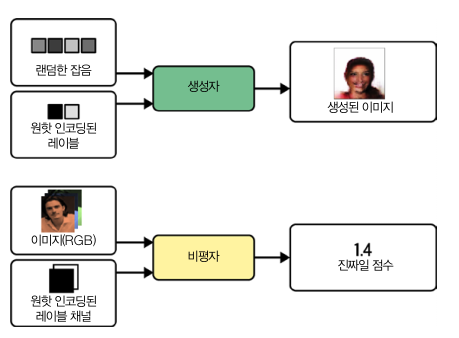

In [1]:
# GAN과 CGAN의 주요한 차이점  : 레이블관련 추가 정보를 생성자와 비평자에게 전달
# 참고 소스 : https://keras.io/examples/generative/conditional_gan/
# 원본 데이터 : https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/code
# 공유폴더 : https://drive.google.com/drive/folders/1amdDBgl7fuv9g92jSlq7mFFYUWs7AsD-?usp=sharing

In [ ]:
!unzip '/content/drive/MyDrive/celeba_face/celebA.zip'

In [2]:
from glob import glob

In [21]:
temp = glob("/content/img_align_celeba/img_align_celeba/*")
temp[:5]

['/content/img_align_celeba/img_align_celeba/140206.jpg',
 '/content/img_align_celeba/img_align_celeba/018991.jpg',
 '/content/img_align_celeba/img_align_celeba/187942.jpg',
 '/content/img_align_celeba/img_align_celeba/032345.jpg',
 '/content/img_align_celeba/img_align_celeba/124028.jpg']

In [8]:
# 라이브러리
import numpy as np
import tensorflow as tf
from tensorflow.keras import(
    layers,models,callbacks,utils,metrics,optimizers
)
# utils.py 파일 필요
from utils import display, sample_batch
import pandas as pd

In [7]:
# 파라메터
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

In [10]:
attributes = pd.read_csv('list_attr_celeba.csv')
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [16]:
int_labels = [1 if i== 1 else 0 for i in attributes[LABEL] ]
int_labels[-5:]

[1, 1, 0, 0, 1]

In [22]:
train_data = utils.image_dataset_from_directory(
   '/content/img_align_celeba/img_align_celeba/',
   labels=int_labels,
   color_mode='rgb',
   image_size = (IMAGE_SIZE,IMAGE_SIZE),
   batch_size = BATCH_SIZE,
   shuffle=True,
   seed=42
)

Found 202599 files belonging to 2 classes.


In [24]:
# 데이터 전처리  라벨링 때문에 onehot
def preprocess(img):
  img = (tf.cast(img,'float32')-127.5) / 127.5
  return img

train = train_data.map( lambda x,y : (preprocess(x), tf.one_hot(y,depth=CLASSES)) )

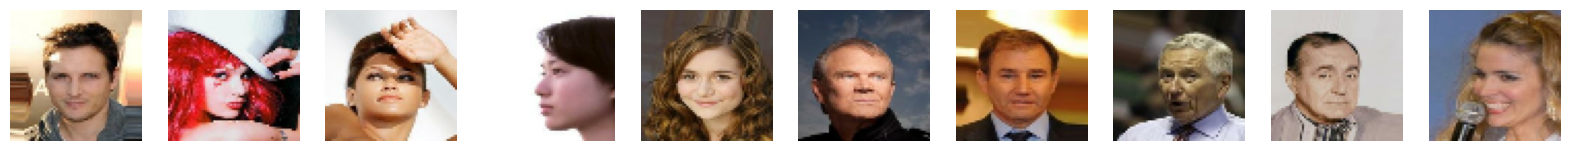

In [27]:
train_sample = sample_batch(train)
display(train_sample)

In [40]:
# 판별자... 비평자
critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CLASSES))
x = layers.Concatenate(axis=-1)([critic_input,label_input])

x = layers.Conv2D(64,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4, strides=1,padding='valid')(x)
critic_output = layers.Flatten()(x)
critic = models.Model([critic_input,label_input]  ,critic_output)
critic.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 64, 64, 5)            0         ['input_7[0][0]',             
 )                                                                   'input_8[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           5184      ['concatenate_3[0][0]'] 

In [30]:
generator_input = layers.Input(shape = (Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input,label_input])

x = layers.Reshape( (1,1,Z_DIM+CLASSES))(x)
x = layers.Conv2DTranspose(128,kernel_size=4, strides=1,padding='valid',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS,kernel_size=4, strides=2,padding='same',activation='tanh')(x)
generator = models.Model([generator_input,label_input],generator_output)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 34)                   0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 34)             0         ['concatenate_2[0][0]'] 

In [39]:
class ConditionalGAN(models.Model):
  def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
    super(ConditionalGAN, self).__init__()
    self.critic = critic
    self.generator = generator
    self.latent_dim = latent_dim
    self.critic_steps = critic_steps
    self.gp_weight = gp_weight

  def compile(self, c_optimizer, g_optimizer):
      super(ConditionalGAN, self).compile()
      self.c_optimizer = c_optimizer
      self.g_optimizer = g_optimizer
      self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
      self.c_gp_metric = metrics.Mean(name="c_gp")
      self.c_loss_metric = metrics.Mean(name="c_loss")
      self.g_loss_metric = metrics.Mean(name="g_loss")

  @property
  def metrics(self):
      return [
          self.c_loss_metric,
          self.c_wass_loss_metric,
          self.c_gp_metric,
          self.g_loss_metric,
      ]
  # 그레이디언트 패널티 손실함수
  def gradient_penalty(self, batch_size,real_images,fake_images, image_one_hot_labels):
    # 배치에 있는 이미지마다 0과 1사이의 랜덤한 숫자를 생성해서 벡터 alpha저장
    alpha = tf.random.normal([batch_size,1,1,1],0.0,1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha*diff # 보간 이미지를 계산

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      pred = self.critic([interpolated,image_one_hot_labels],training=True) # 비평가한테 보간된 이미지의 점수를 요청

    grads = gp_tape.gradient(pred, [interpolated])[0] # 보간된 이미지에 대해서 예측에 대한 기울기 계산
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3])) # 벡터의 L2노름을 계산
    # L2노름 : 벡터나 행렬의 크기, 길이를 측정 유클리드 노름 (||x||2)
    # 각 요소의 제곱을 더하고 그 합에 제곱근
    gp = tf.reduce_mean((norm-1.0)**2) # L2노름과 1사이의 평균 제곱 거리를 반환
    return gp

  def train_step(self, data):
        real_images, one_hot_labels = data
        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [41]:
#CGAN 생성
cgan = ConditionalGAN(critic=critic,generator=generator,latent_dim=Z_DIM,critic_steps=CRITIC_STEPS,gp_weight=GP_WEIGHT)


In [42]:
# 컴파일
cgan.compile(
    c_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=ADAM_BETA_1,beta_2=ADAM_BETA_2),
    g_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=ADAM_BETA_1,beta_2=ADAM_BETA_2),
)

In [43]:
# 체크포인트
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = "/content/drive/MyDrive/celeba_face/cgan/checkpoint.ckpt",
    save_weights_only = True,
    save_freq = 'epoch',
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [46]:
class ImageGenerator(callbacks.Callback):
  def __init__(self, num_img, latent_dim):
      self.num_img = num_img
      self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(
        shape=(self.num_img, self.latent_dim)
    )
    # 0 레이블
    zero_label = np.repeat([[1,0]], self.num_img, axis=0)
    generated_images = self.model.generator([random_latent_vectors,zero_label])

    generated_images = generated_images * 127.5 + 127.5
    generated_images = generated_images.numpy()
    if epoch % 10 == 0: # 출력횟수 줄이기:
      display(
        generated_images,
        save_to="/content/drive/MyDrive/celeba_face/cgan/generated_img_%03d_label_0.png" % (epoch),
        cmap=None,
      )

   # 1 레이블
    one_label = np.repeat([[0,1]], self.num_img, axis=0)
    generated_images = self.model.generator([random_latent_vectors,one_label])

    generated_images = generated_images * 127.5 + 127.5
    generated_images = generated_images.numpy()
    if epoch % 10 == 0: # 출력횟수 줄이기:
      display(
        generated_images,
        save_to="/content/drive/MyDrive/celeba_face/cgan/generated_img_%03d_label_1.png" % (epoch),
        cmap=None,
      )

Epoch 1/20
1/1 [==============================] - ETA: 0s - c_loss: 7.2534 - c_wass_loss: -0.1359 - c_gp: 0.7389 - g_loss: 0.0158
Saved to /content/drive/MyDrive/celeba_face/cgan/generated_img_000_label_0.png


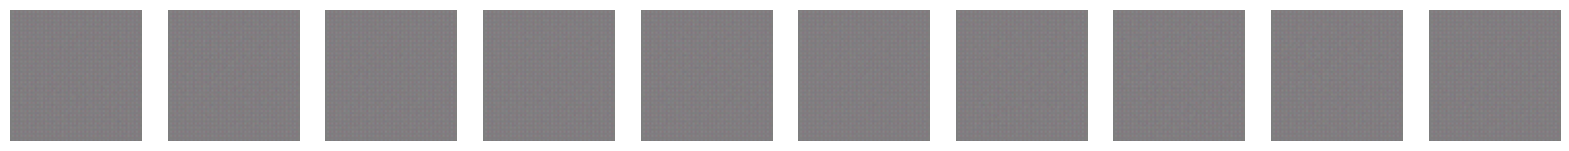


Saved to /content/drive/MyDrive/celeba_face/cgan/generated_img_000_label_1.png


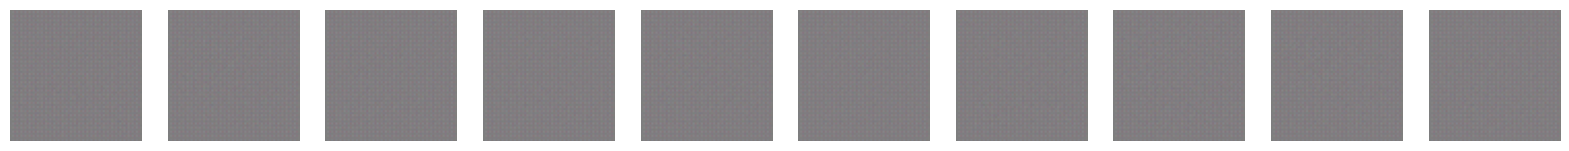

1/1 [==============================] - 4s 4s/step - c_loss: 7.2534 - c_wass_loss: -0.1359 - c_gp: 0.7389 - g_loss: 0.0158
Epoch 2/20
1/1 [==============================] - 1s 655ms/step - c_loss: 6.9774 - c_wass_loss: -0.2914 - c_gp: 0.7269 - g_loss: 0.0456
Epoch 3/20
1/1 [==============================] - 1s 607ms/step - c_loss: 6.6504 - c_wass_loss: -0.4393 - c_gp: 0.7090 - g_loss: 0.0287
Epoch 4/20
1/1 [==============================] - 1s 564ms/step - c_loss: 6.1836 - c_wass_loss: -0.7314 - c_gp: 0.6915 - g_loss: 0.0467
Epoch 5/20
1/1 [==============================] - 1s 557ms/step - c_loss: 5.5243 - c_wass_loss: -1.1260 - c_gp: 0.6650 - g_loss: 0.0965
Epoch 6/20
1/1 [==============================] - 1s 795ms/step - c_loss: 4.8086 - c_wass_loss: -1.6392 - c_gp: 0.6448 - g_loss: 0.1368
Epoch 7/20
1/1 [==============================] - 1s 563ms/step - c_loss: 3.7660 - c_wass_loss: -2.4013 - c_gp: 0.6167 - g_loss: 0.2565
Epoch 8/20
1/1 [==============================] - 1s 568ms/ste

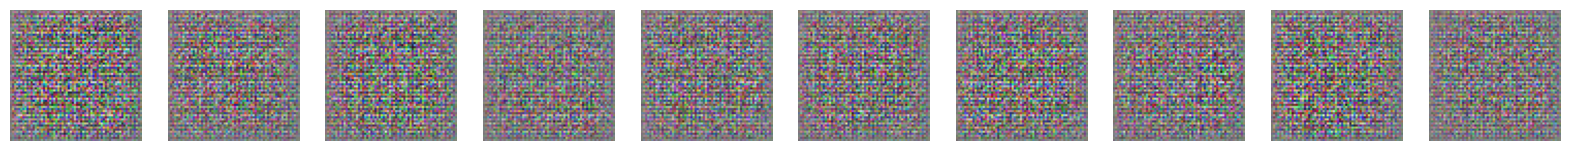


Saved to /content/drive/MyDrive/celeba_face/cgan/generated_img_010_label_1.png


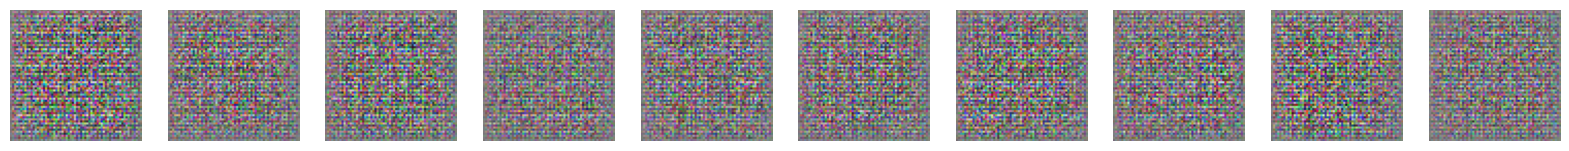

1/1 [==============================] - 2s 2s/step - c_loss: -4.7039 - c_wass_loss: -8.9807 - c_gp: 0.4277 - g_loss: 1.6617
Epoch 12/20
1/1 [==============================] - 1s 685ms/step - c_loss: -8.4537 - c_wass_loss: -12.0497 - c_gp: 0.3596 - g_loss: 2.2299
Epoch 13/20
1/1 [==============================] - 1s 659ms/step - c_loss: -13.0204 - c_wass_loss: -15.7153 - c_gp: 0.2695 - g_loss: 3.0590
Epoch 14/20
1/1 [==============================] - 1s 995ms/step - c_loss: -18.3764 - c_wass_loss: -20.1845 - c_gp: 0.1808 - g_loss: 4.0003
Epoch 15/20
1/1 [==============================] - 1s 660ms/step - c_loss: -24.0675 - c_wass_loss: -25.2689 - c_gp: 0.1201 - g_loss: 5.1003
Epoch 16/20
1/1 [==============================] - 1s 631ms/step - c_loss: -30.5287 - c_wass_loss: -31.1201 - c_gp: 0.0591 - g_loss: 6.5563
Epoch 17/20
1/1 [==============================] - 1s 690ms/step - c_loss: -37.2825 - c_wass_loss: -37.9425 - c_gp: 0.0660 - g_loss: 8.3709
Epoch 18/20
1/1 [=====================

In [47]:
history = cgan.fit(train,epochs = EPOCHS, steps_per_epoch=1,
                   callbacks = [
                      model_checkpoint_callback,
                      tensorboard_callback,
                      ImageGenerator(num_img=10,latent_dim=Z_DIM)
                   ]  )